In [99]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

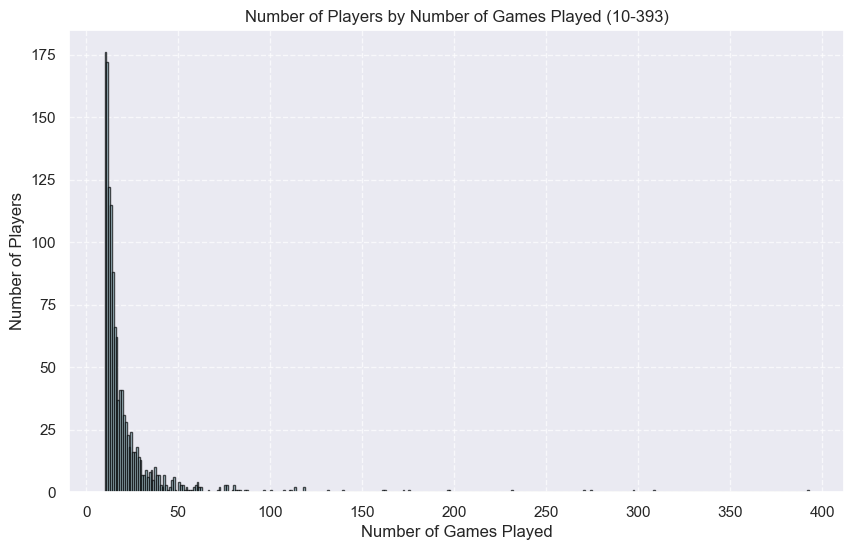

In [100]:
df_f = pd.DataFrame
parent_directory = "../Data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/"
df_f = pd.read_csv(parent_directory + "paths_finished.tsv", sep='\t', skiprows=17, skip_blank_lines=True)
df_u = pd.read_csv(parent_directory + "paths_unfinished.tsv", sep='\t', skiprows=16, skip_blank_lines=True)

np.set_printoptions(threshold=sys.maxsize)

df_f.columns = ['UID', 'timestamp', 'duration', 'path', 'rating']
df_u.columns = ['UID', 'timestamp', 'duration', 'path', 'target', 'type']

#Converting to correct time stamps
#df_f['timestamp'] = pd.to_datetime(df_f['timestamp'], unit='s')
#df_u['timestamp'] = pd.to_datetime(df_u['timestamp'], unit='s')

#Complete Datafranes 
df_games = pd.concat([df_f.drop(columns=['rating']), df_u.drop(columns=['target', 'type'])], ignore_index=True)

# Unique values
groups_f = df_f['UID'].value_counts()
groups_u = df_u['UID'].value_counts()

combined_counts = groups_f.add(groups_u, fill_value=0)

filtered_counts = combined_counts[(combined_counts >= 10) & (combined_counts <= 400)].sort_values(ascending=False)

min_games = int(filtered_counts.min())
max_games = int(filtered_counts.max())

game_range = range(min_games, max_games + 1)

players_count = [len(filtered_counts[filtered_counts >= game_count]) for game_count in game_range]

sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(filtered_counts, bins=game_range, color='lightblue', edgecolor='black', alpha=0.7)

ax.set_xlabel("Number of Games Played")
ax.set_ylabel("Number of Players")
ax.set_title(f"Number of Players by Number of Games Played ({min_games}-{max_games})")
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [101]:
display(df_games)

,UID,timestamp,duration,path
0,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...
1,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece
2,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...
3,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...
4,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire
...,...,...,...,...
76185,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...
76186,232f992e57d43e8d,1389787697,6,Modern_history
76187,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...
76188,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...


In [103]:
def analyze_duration_variation3(df):
    df['start_location'] = df['path'].apply(lambda x: x.split(';')[0])
    df['end_location'] = df['path'].apply(lambda x: x.split(';')[-1])
    df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))

    grouped_df = df.groupby(['UID', 'start_location', 'end_location']).agg(
        games=('duration', 'count'),
        #duration=('duration', 'first'), # includes a column duration with value the first of the set
        duration_mean_s=('duration', 'mean'),
        #timestamp_std_h=('timestamp', 'std'),
        timestamp_min=('timestamp', 'min'),
        timestamp_max=('timestamp', 'max'),
        duration_min=('duration', 'min'),
        duration_max=('duration', 'max'),
        #timestamp=('timestamp', 'first'),
        #path_length=('path_length', 'max') 
    ).reset_index()

    grouped_df['time_diff_s'] = (grouped_df['timestamp_max'] - grouped_df['timestamp_min'])
    grouped_df["time_diff_s"] = grouped_df["time_diff_s"] // 3600
    grouped_df['duration_mean_s'] = grouped_df['duration_mean_s'].round(5)
        #grouped_df['timestamp'] = pd.to_datetime(grouped_df['timestamp'], unit='s')
    grouped_df = grouped_df[grouped_df['games'] > 2]
    grouped_df = grouped_df.sort_values(by='games', ascending=True)

    for (index, row) in grouped_df.iterrows():
        uid = row['UID']
        start_location = row['start_location']
        end_location = row['end_location']
        subset_df = df_games[(df_games['UID'] == uid) & (df_games['start_location'] == start_location) & (df_games['end_location'] == end_location)]
        
        delta_duration = subset_df['duration'].diff()
        delta_length = subset_df['path_length'].diff()
        average_duration = delta_duration.iloc[1:].mean()
        average_path_length = delta_length.iloc[1:].mean()
        grouped_df.loc[index, 'delta_duration'] = average_duration
        grouped_df.loc[index, 'avg_path_length'] = average_path_length

    return grouped_df[['UID', 'start_location', 'end_location', 'games', 'duration_mean_s',
                        'delta_duration','time_diff_s','avg_path_length']]

variation_table = analyze_duration_variation3(df_games)


In [105]:
variation_table.sort_values('games').head(3)

,UID,start_location,end_location,games,duration_mean_s,delta_duration,time_diff_s,avg_path_length
245,009a5dfb08085fd4,New_York_City,North_America,3,6.000,0.0,0,0.0
9977,0d57c8c57d75e2f5,Ottoman_Empire,Dublin,3,82.667,11.5,3331,0.0
9980,0d57c8c57d75e2f5,Owl,Engineering,3,62.000,29.5,0,2.0


In [ ]:
display(df_games[(df_games['UID']=='0d57c8c57d75e2f5') & (df_games['start_location']=='Owl') & ((df_games['end_location']=='Engineering'))])

,UID,timestamp,duration,path,start_location,end_location,path_length,deltas,delta_t
19527,0d57c8c57d75e2f5,2010-12-16 14:22:37,35,Owl;Ecology;Physics;Engineering,Owl,Engineering,4,-94.0,29.5
19528,0d57c8c57d75e2f5,2010-12-16 14:23:09,57,Owl;Ecology;Physics;Engineering,Owl,Engineering,4,22.0,29.5
19529,0d57c8c57d75e2f5,2010-12-16 14:23:34,94,Owl;Maya_civilization;Civilization;University;...,Owl,Engineering,8,37.0,29.5


In [116]:
def scatter_duration_variation(duration_variation):
    # Plot 1: Relation between Number of Games and Delta Duration
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='games', y='delta_duration', data=duration_variation)
    plt.title('Number of Games vs Delta Duration')

    # Plot 2: Relation between Number of Games and Average Path Length
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='games', y='avg_path_length', data=duration_variation)
    plt.title('Number of Games vs Average Path Length')

    plt.tight_layout()
    plt.show()

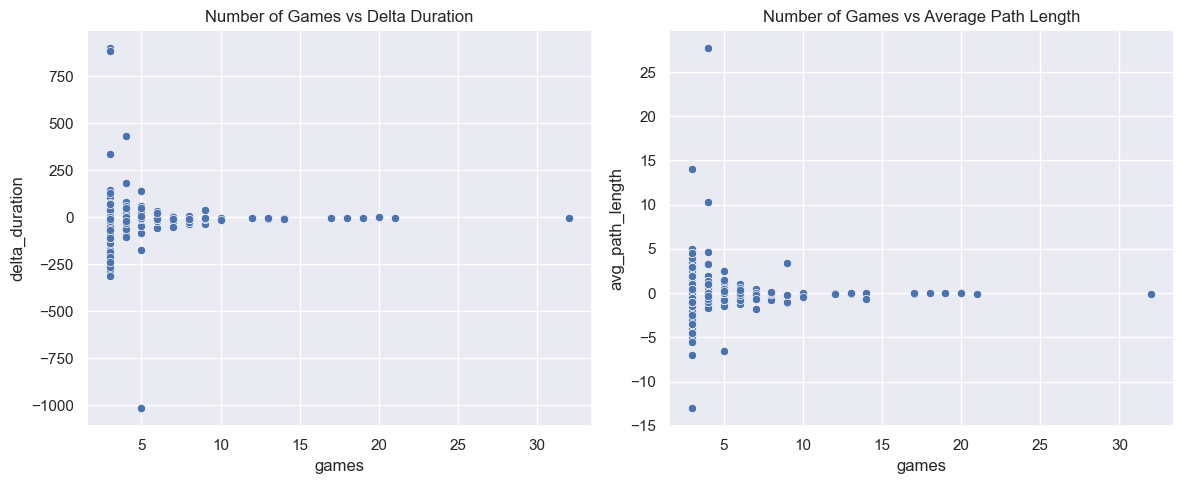

In [117]:
scatter_duration_variation(variation_table)

/var/folders/px/v8m1fh9j1ng0_km3w7m2cyph0000gn/T/ipykernel_717/3343225325.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='games', y='delta_duration', data=variation_table, palette='viridis')


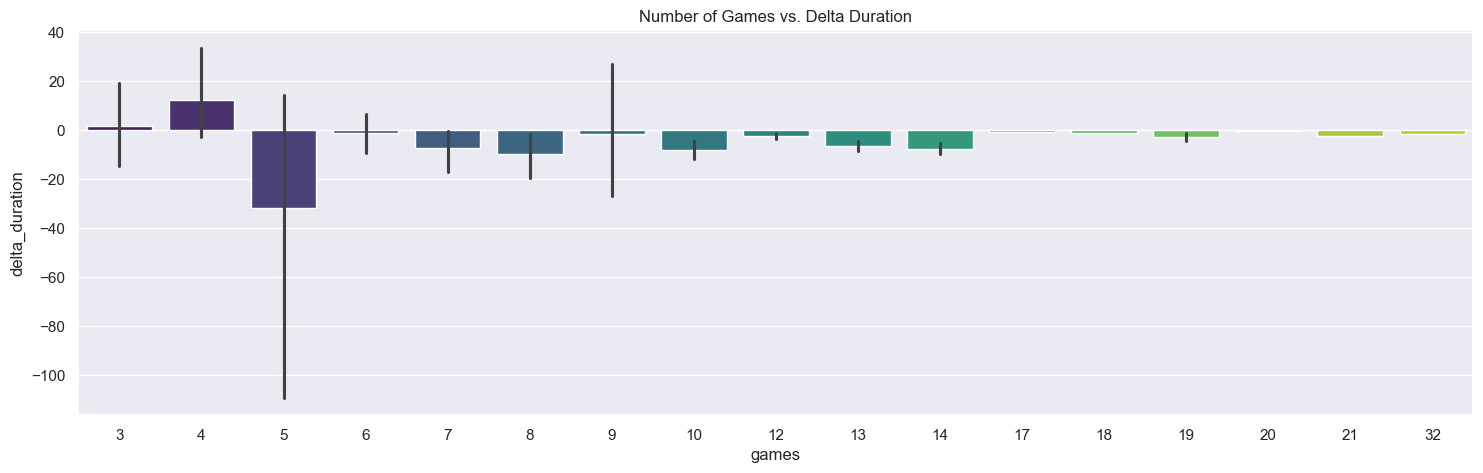

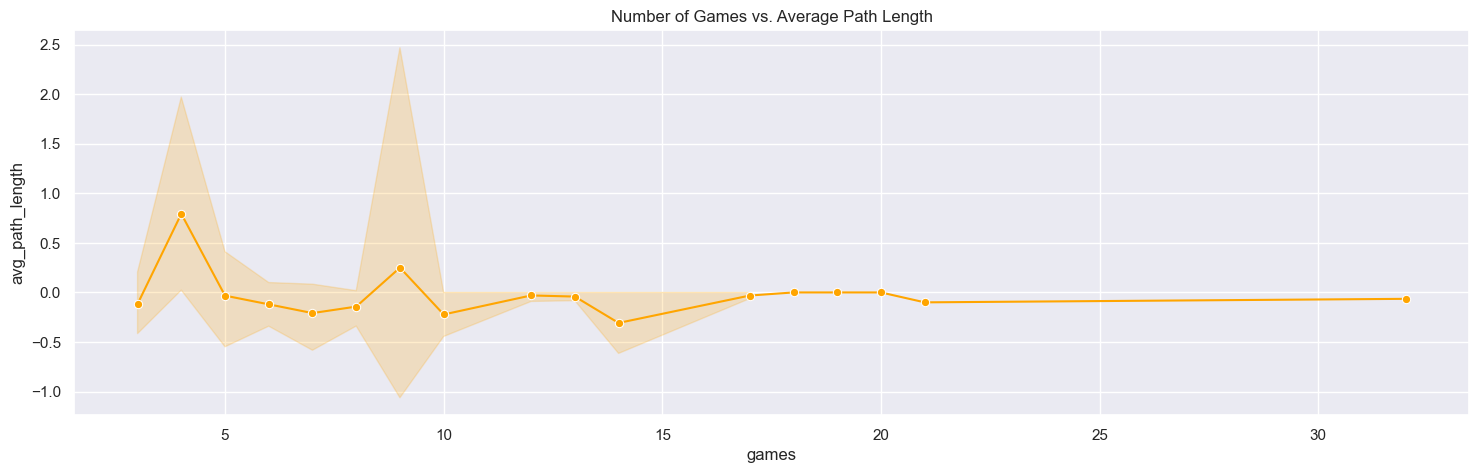

<Figure size 1800x500 with 0 Axes>

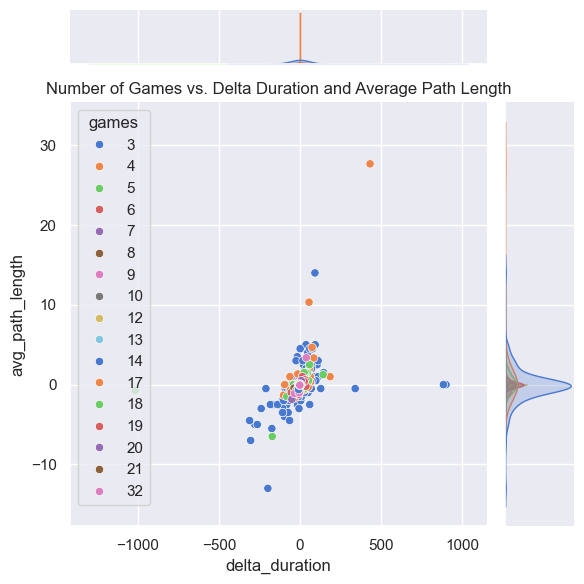

In [109]:
# Multiplicatory factor of 10 for the graphs
# Bar Plot - Number of Games vs. Delta Duration
plt.figure(figsize=(18, 5))
sns.barplot(x='games', y='delta_duration', data=variation_table, palette='viridis')
plt.title('Number of Games vs. Delta Duration')

# Line Plot - Number of Games vs. Average Path Length
plt.figure(figsize=(18, 5))
sns.lineplot(x='games', y='avg_path_length', data=variation_table, marker='o', color='orange')
plt.title('Number of Games vs. Average Path Length')

# Joint Plot - Number of Games vs. Delta Duration and Average Path Length
plt.figure(figsize=(18, 5))
sns.jointplot(x='delta_duration', y='avg_path_length', data=variation_table, kind='scatter', hue='games', palette='muted')
plt.title('Number of Games vs. Delta Duration and Average Path Length')

plt.tight_layout()
plt.show()